In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("eye_data.csv")
df.head()


,timestamp,left_ear,right_ear,avg_ear,label
0,1.767226e+09,0.344766,0.333667,0.339217,0
1,1.767226e+09,0.341549,0.350060,0.345804,0
2,1.767226e+09,0.331214,0.350060,0.340637,0
3,1.767226e+09,0.316238,0.308958,0.312598,0
4,1.767226e+09,0.299640,0.301390,0.300515,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3062 entries, 0 to 3061
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3062 non-null   float64
 1   left_ear   3062 non-null   float64
 2   right_ear  3062 non-null   float64
 3   avg_ear    3062 non-null   float64
 4   label      3062 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 119.7 KB


In [4]:
df.describe()

,timestamp,left_ear,right_ear,avg_ear,label
count,3.062000e+03,3062.000000,3062.000000,3062.000000,3062.000000
mean,1.767270e+09,0.222940,0.221470,0.222205,0.279229
std,2.885769e+04,0.091107,0.092634,0.091326,0.448694
min,1.767226e+09,0.000000,0.000000,0.000000,0.000000
25%,1.767226e+09,0.172388,0.173422,0.171190,0.000000
50%,1.767289e+09,0.251650,0.250234,0.252405,0.000000
75%,1.767289e+09,0.285443,0.287803,0.287053,1.000000
max,1.767289e+09,0.388707,0.368040,0.370407,1.000000


In [5]:
df['label'].value_counts(normalize=True)


label
0    0.720771
1    0.279229
Name: proportion, dtype: float64

In [6]:
df = df.dropna()
df = df[(df['avg_ear'] > 0.05) & (df['avg_ear'] < 0.5)]


## Feature 1: Average EAR Smooth

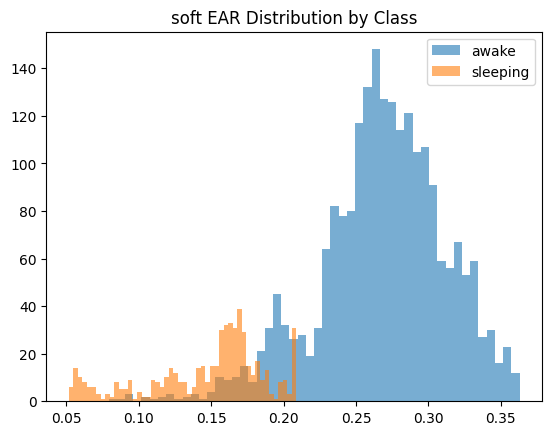

In [7]:
# we use a window of 5 frames (~0.15 secs) to ignore quick blinks
df['avg_ear_smooth'] = df['avg_ear'].rolling(window=5, center=True).mean()
df = df.dropna()
df.head()

plt.hist(df[df.label==0]['avg_ear_smooth'], bins=50, alpha=0.6, label='awake')
plt.hist(df[df.label==1]['avg_ear_smooth'], bins=50, alpha=0.6, label='sleeping')
plt.legend()
plt.title("soft EAR Distribution by Class")
plt.show()


## Feature 2: Differential EAR

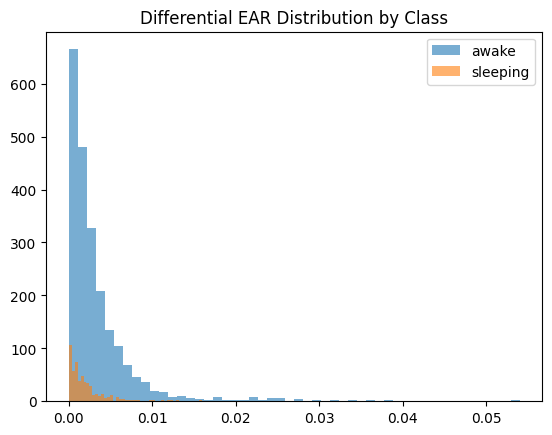

In [8]:
# differential EAR
df['diff_ear_smooth'] = df['avg_ear_smooth'].diff().abs()
df = df.dropna()
df.head()
plt.hist(df[df.label==0]['diff_ear_smooth'], bins=50, alpha=0.6, label='awake')
plt.hist(df[df.label==1]['diff_ear_smooth'], bins=50, alpha=0.6, label='sleeping')
plt.legend()
plt.title("Differential EAR Distribution by Class")
plt.show()


## Feature 3: Local EAR variance 

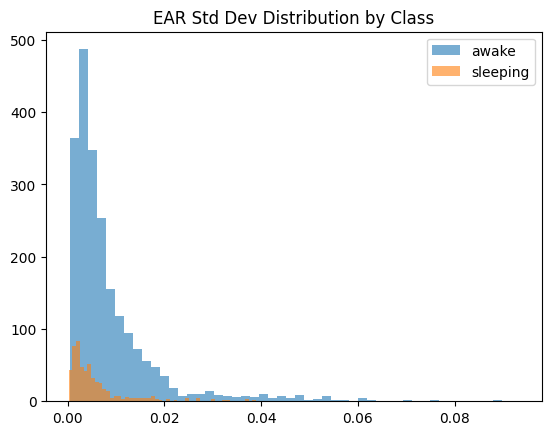

In [9]:
df['ear_std'] = df['avg_ear_smooth'].rolling(10).std()
df = df.dropna()
df.head()
plt.hist(df[df.label==0]['ear_std'], bins=50, alpha=0.6, label='awake')
plt.hist(df[df.label==1]['ear_std'], bins=50, alpha=0.6, label='sleeping')
plt.legend()
plt.title("EAR Std Dev Distribution by Class")
plt.show()

## Prediction models.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc

In [11]:
X = df[['avg_ear_smooth', 'diff_ear_smooth', 'ear_std']] 
y = df['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

## Model 1: Bayes

In [12]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

acc_gnb = accuracy_score(y_test, y_pred_gnb)
print(f"Precisión (Accuracy): {acc_gnb:.4f}")
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_gnb))

Precisión (Accuracy): 0.9334
Matriz de Confusión:
 [[624  36]
 [ 19 147]]


In [13]:
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_gnb))
recall = recall_score(y_test, y_pred_gnb)
precision = precision_score(y_test, y_pred_gnb)
f1 = f1_score(y_test, y_pred_gnb)
print(f"Recall: {recall:.4f}, Precision: {precision:.4f}, F1-Score: {f1:.4f}")


Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       660
           1       0.80      0.89      0.84       166

    accuracy                           0.93       826
   macro avg       0.89      0.92      0.90       826
weighted avg       0.94      0.93      0.93       826

Recall: 0.8855, Precision: 0.8033, F1-Score: 0.8424


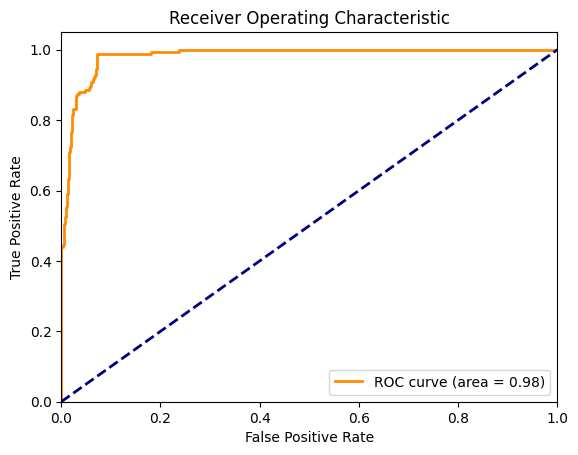

AUC: 0.9834


In [14]:
#AUC ROC Curve

y_prob_gnb = gnb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gnb)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.4f}")

## Model 2: SVM

In [15]:
svc = SVC(kernel='rbf', C=1.0, gamma='scale')
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

acc_svc = accuracy_score(y_test, y_pred_svc)
print(f"Precisión (Accuracy) SVC: {acc_svc:.4f}")
print("Matriz de Confusión SVC:\n", confusion_matrix(y_test, y_pred_svc))


Precisión (Accuracy) SVC: 0.9479
Matriz de Confusión SVC:
 [[635  25]
 [ 18 148]]


In [16]:
print("Reporte de Clasificación SVC:\n", classification_report(y_test, y_pred_svc))
recall_svc = recall_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc)
print(f"SVC Recall: {recall_svc:.4f}, Precision: {precision_svc:.4f}, F1-Score: {f1_svc:.4f}")


Reporte de Clasificación SVC:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       660
           1       0.86      0.89      0.87       166

    accuracy                           0.95       826
   macro avg       0.91      0.93      0.92       826
weighted avg       0.95      0.95      0.95       826

SVC Recall: 0.8916, Precision: 0.8555, F1-Score: 0.8732


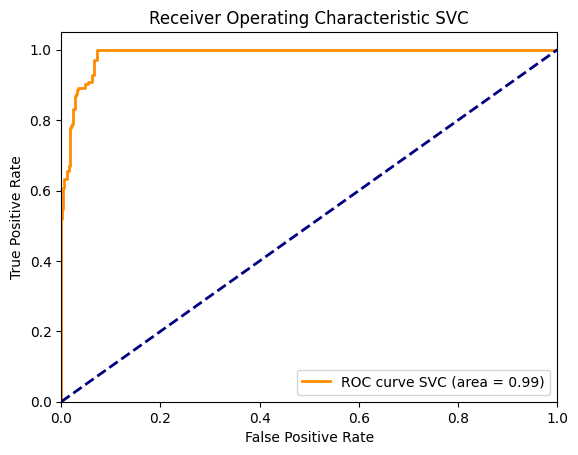

AUC SVC: 0.9874


In [17]:
y_prob_svc = svc.decision_function(X_test)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_prob_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)
plt.figure()
plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=2, label='ROC curve SVC (area = %0.2f)' % roc_auc_svc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic SVC')
plt.legend(loc="lower right")
plt.show()

print(f"AUC SVC: {roc_auc_svc:.4f}")

## Model 3: adaptive threshold

In [18]:
# adaptative threshdold

best_threshold = 0
best_acc = 0

thresholds = np.linspace(0.15, 0.35, 100)
for th in thresholds:
    y_pred_manual = (X_test['avg_ear_smooth'] < th).astype(int)
    acc = accuracy_score(y_test, y_pred_manual)
    if acc > best_acc:
        best_acc = acc
        best_threshold = th

print(f"Mejor Umbral encontrado: {best_threshold:.4f}")
print(f"Precisión con este umbral: {best_acc:.4f}")

Mejor Umbral encontrado: 0.1843
Precisión con este umbral: 0.9407


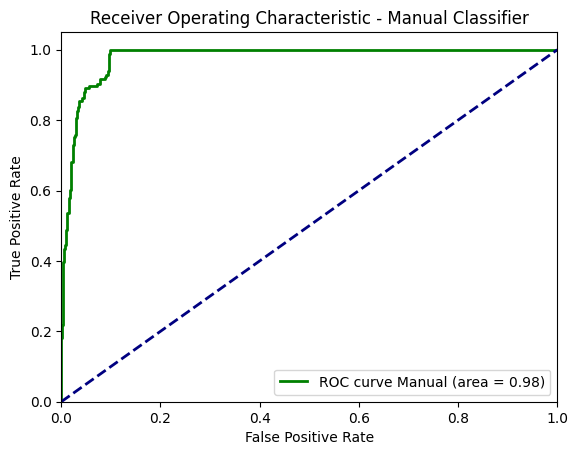

AUC Manual Classifier: 0.9792


In [19]:
y_prob_manual = 1 - X_test['avg_ear_smooth']  
fpr_manual, tpr_manual, thresholds_manual = roc_curve(y_test, y_prob_manual)
roc_auc_manual = auc(fpr_manual, tpr_manual)
plt.figure()
plt.plot(fpr_manual, tpr_manual, color='green', lw=2, label='ROC curve Manual (area = %0.2f)' % roc_auc_manual)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Manual Classifier')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Manual Classifier: {roc_auc_manual:.4f}")